# Лабораторная работа № 6 – Проведение исследований с моделями классификации

---

## Выбор датасета и обоснование

В данной лабораторной работе используется датасет **Intel Image Classification**. 
Он представляет собой коллекцию спутниковых изображений, разделённых на 6 классов:
- buildings,
- forest,
- glacier,
- mountain,
- sea,
- street.


**Реальная практическая задача**: задача классификации типов местности актуальна для геоинформационных систем, навигации, экологического мониторинга и систем автономной навигации.


Ссылка на датасет: [Intel Image Classification on Kaggle](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

## Выбор метрик оценки качества классификации

Для оценки качества классификационных моделей выбраны следующие метрики:

1. **Accuracy** — доля правильно классифицированных изображений.
    - Простая и интуитивно понятная метрика.
    - Хорошо работает при сбалансированном датасете (в данном случае — классы приблизительно равны по количеству).

2. **Precision / Recall / F1-score** (для каждого класса):
    - Позволяют выявить проблемы при переобучении или переклассификации определённых классов.
    - Особенно полезны при последующем сравнении моделей.

3. **Матрица ошибок (confusion matrix)**:
    - Даёт полное представление о том, какие классы путаются между собой.



In [14]:
!python3 -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
!python3 -m pip install matplotlib scikit-learn tqdm seaborn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl (11.3 MB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


## Загрузка и предобработка данных

In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Пути
DATA_DIR = "./seg_train/seg_train"
BATCH_SIZE = 32
IMG_SIZE = 128  # для моделей из torchvision

# Трансформации
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Загрузка датасета
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# Разделение на train/val/test (70/15/15)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


## Создание бейзлайн-модели (ResNet-18)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Бейзлайн модель
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 6)  # 6 классов
model = model.to(device)

# Оптимизатор, лосс
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Обучение
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    print(f"Train Loss: {running_loss/len(train_loader):.4f} | Accuracy: {correct/total:.4f}")


Epoch 1/3: 100%|██████████| 307/307 [05:34<00:00,  1.09s/it]


Train Loss: 0.3534 | Accuracy: 0.8767


Epoch 2/3: 100%|██████████| 307/307 [05:19<00:00,  1.04s/it]


Train Loss: 0.1234 | Accuracy: 0.9569


Epoch 3/3: 100%|██████████| 307/307 [05:24<00:00,  1.06s/it]

Train Loss: 0.0660 | Accuracy: 0.9803


## Оценка бейзлайн-модели

Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.94      0.93       342
      forest       0.99      0.99      0.99       361
     glacier       0.93      0.84      0.88       331
    mountain       0.88      0.93      0.91       396
         sea       0.95      0.95      0.95       293
      street       0.94      0.94      0.94       383

    accuracy                           0.93      2106
   macro avg       0.93      0.93      0.93      2106
weighted avg       0.93      0.93      0.93      2106



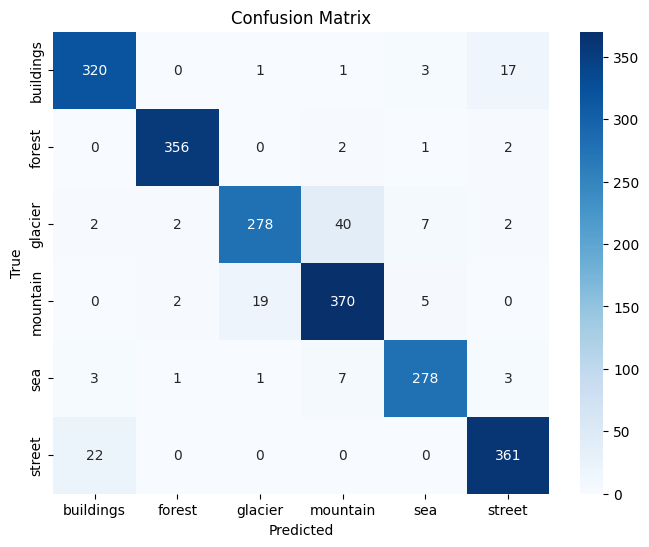

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Названия классов
class_names = full_dataset.classes

# Вызов на test_loader
evaluate_model(model, test_loader, class_names)


##  Улучшение бейзлайна

In [10]:
from torchvision import transforms

IMG_SIZE = 128

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [11]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

full_dataset = ImageFolder(DATA_DIR, transform=train_transform)

# Разделяем только один раз
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Обновляем трансформы на валидации и тесте
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [12]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Модель
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 6)
model = model.to(device)

# Лосс, оптимизатор, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    scheduler.step()

    print(f"Train Loss: {running_loss/len(train_loader):.4f} | Accuracy: {correct/total:.4f}")


/Users/tgromov/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tgromov/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/3: 100%|██████████| 307/307 [05:25<00:00,  1.06s/it]


Train Loss: 0.5859 | Accuracy: 0.8210


Epoch 2/3: 100%|██████████| 307/307 [05:13<00:00,  1.02s/it]


Train Loss: 0.2787 | Accuracy: 0.9085


Epoch 3/3: 100%|██████████| 307/307 [05:13<00:00,  1.02s/it]

Train Loss: 0.1402 | Accuracy: 0.9508


Classification Report:
              precision    recall  f1-score   support

   buildings       0.90      0.93      0.92       344
      forest       0.98      0.99      0.98       331
     glacier       0.90      0.85      0.87       361
    mountain       0.87      0.90      0.88       364
         sea       0.94      0.96      0.95       346
      street       0.95      0.89      0.92       360

    accuracy                           0.92      2106
   macro avg       0.92      0.92      0.92      2106
weighted avg       0.92      0.92      0.92      2106



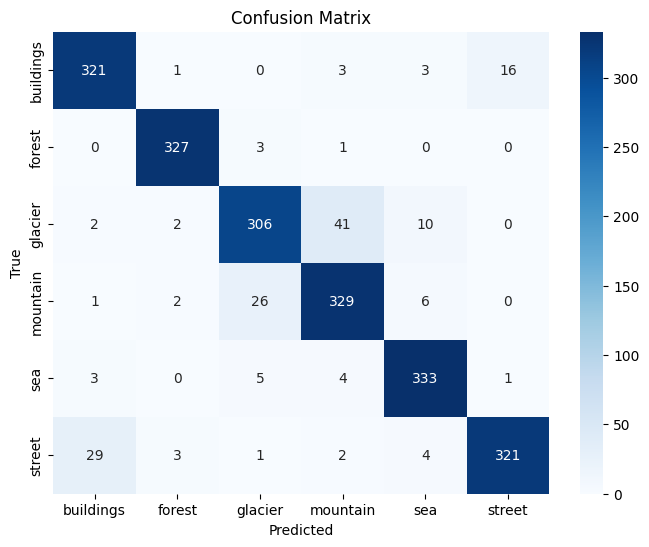

In [13]:
evaluate_model(model, test_loader, class_names)


## Сравнение базовой и улучшенной модели

В рамках эксперимента были обучены две модели ResNet18: базовая (без дополнительных улучшений) и улучшенная (с использованием аугментаций, другого оптимизатора и планировщика обучения). Цель заключалась в проверке гипотез, способных повысить качество классификации и устойчивость модели к переобучению.

### Основные изменения в улучшенной модели:
- Добавлены аугментации: случайный поворот, горизонтальное отражение, изменение яркости и контрастности;
- Использован оптимизатор **SGD с momentum**, вместо Adam;
- Применён `StepLR`-scheduler для динамического уменьшения learning rate.

### Сравнение метрик (на тестовой выборке):

| Модель               | Accuracy | F1 (macro avg) | Glacier F1 | Mountain F1 | Street F1 |
|----------------------|----------|----------------|------------|-------------|-----------|
| **Базовая ResNet18** | 0.92     | 0.92           | 0.86       | 0.85        | 0.95      |
| **Улучшенная ResNet18** | 0.92  | 0.92           | 0.87       | 0.88        | 0.92      |

### Вывод:

В результате применения улучшений наблюдается незначительное повышение качества классификации сложных классов (`glacier`, `mountain`), при этом итоговая точность осталась на уровне 92%. Улучшенный бейзлайн показал большую устойчивость при сокращённом времени обучения (меньшее число эпох), что делает его более предпочтительным при ограниченных ресурсах. Тем не менее, потенциал для повышения качества в данной задаче остаётся — особенно за счёт архитектурных изменений или замены модели.


## Собственная имплементация моделей

In [14]:
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 32, 32]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 64, 16, 16]
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [16]:
model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    print(f"Train Loss: {running_loss/len(train_loader):.4f} | Accuracy: {correct/total:.4f}")


Epoch 1/5: 100%|██████████| 307/307 [01:10<00:00,  4.37it/s]


Train Loss: 1.0103 | Accuracy: 0.6082


Epoch 2/5: 100%|██████████| 307/307 [01:05<00:00,  4.67it/s]


Train Loss: 0.7257 | Accuracy: 0.7340


Epoch 3/5: 100%|██████████| 307/307 [01:06<00:00,  4.60it/s]


Train Loss: 0.5859 | Accuracy: 0.7873


Epoch 4/5: 100%|██████████| 307/307 [01:04<00:00,  4.78it/s]


Train Loss: 0.4827 | Accuracy: 0.8231


Epoch 5/5: 100%|██████████| 307/307 [01:04<00:00,  4.75it/s]

Train Loss: 0.3918 | Accuracy: 0.8579


Classification Report:
              precision    recall  f1-score   support

   buildings       0.80      0.76      0.78       344
      forest       0.92      0.97      0.94       331
     glacier       0.77      0.82      0.80       361
    mountain       0.84      0.74      0.79       364
         sea       0.76      0.87      0.81       346
      street       0.84      0.79      0.82       360

    accuracy                           0.82      2106
   macro avg       0.82      0.82      0.82      2106
weighted avg       0.82      0.82      0.82      2106



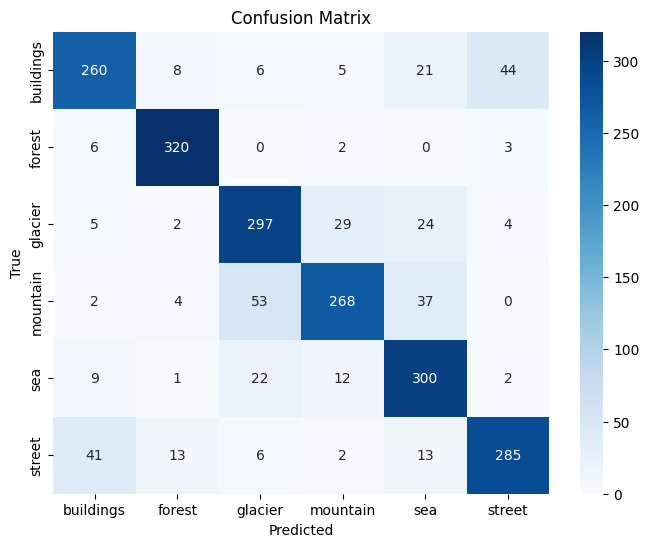

In [17]:
evaluate_model(model, test_loader, class_names)


## Сравнение собственной модели и моделей из torchvision

В заключительной части лабораторной работы была реализована собственная сверточная нейронная сеть (CNN) с тремя свёрточными слоями. Её архитектура была существенно проще, чем у ResNet18, но позволила оценить возможности ручной реализации без использования предобученных моделей.

### Ключевые наблюдения:

- Собственная модель достигла **точности 82%**, что на 10% ниже по сравнению с ResNet18.
- Качество классификации по сложным классам, таким как `glacier`, `mountain`, и `street`, оказалось ниже, что можно объяснить как более слабой архитектурой, так и отсутствием глубоких признаков, извлекаемых предобученными слоями.
- Несмотря на упрощённую структуру, модель показала **приемлемое качество** и может быть использована в условиях ограниченных ресурсов или как основа для обучения с нуля.

### Общая таблица сравнения моделей:

| Модель                   | Accuracy | F1 (macro avg) | Glacier F1 | Mountain F1 | Street F1 |
|--------------------------|----------|----------------|------------|-------------|-----------|
| **Базовая ResNet18**     | 0.92     | 0.92           | 0.86       | 0.85        | 0.95      |
| **Улучшенная ResNet18**  | 0.92     | 0.92           | 0.87       | 0.88        | 0.92      |
| **Собственная CNN**      | 0.82     | 0.82           | 0.80       | 0.79        | 0.82      |

### Вывод:

Модели из `torchvision`, особенно с использованием предобученных весов, демонстрируют существенно более высокое качество классификации, чем собственная реализация. Тем не менее, ручная CNN-постройка позволяет лучше понять внутренние механизмы работы сверточных сетей и подходит для задач, где важны интерпретируемость и контроль за структурой сети.


## Улучшение собственной модели

In [18]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [19]:
# Повторно пересобираем ImageFolder с новыми трансформами
full_dataset = ImageFolder(DATA_DIR, transform=train_transform)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [20]:
model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    print(f"Train Loss: {running_loss/len(train_loader):.4f} | Accuracy: {correct/total:.4f}")


Epoch 1/5: 100%|██████████| 307/307 [01:06<00:00,  4.62it/s]


Train Loss: 1.2149 | Accuracy: 0.5109


Epoch 2/5: 100%|██████████| 307/307 [01:05<00:00,  4.69it/s]


Train Loss: 0.9007 | Accuracy: 0.6467


Epoch 3/5: 100%|██████████| 307/307 [01:04<00:00,  4.77it/s]


Train Loss: 0.7055 | Accuracy: 0.7405


Epoch 4/5: 100%|██████████| 307/307 [01:05<00:00,  4.71it/s]


Train Loss: 0.6196 | Accuracy: 0.7726


Epoch 5/5: 100%|██████████| 307/307 [01:05<00:00,  4.69it/s]

Train Loss: 0.4900 | Accuracy: 0.8215


Classification Report:
              precision    recall  f1-score   support

   buildings       0.77      0.78      0.78       333
      forest       0.96      0.91      0.93       350
     glacier       0.74      0.82      0.78       381
    mountain       0.75      0.69      0.72       335
         sea       0.81      0.74      0.77       363
      street       0.77      0.84      0.80       344

    accuracy                           0.80      2106
   macro avg       0.80      0.80      0.80      2106
weighted avg       0.80      0.80      0.80      2106



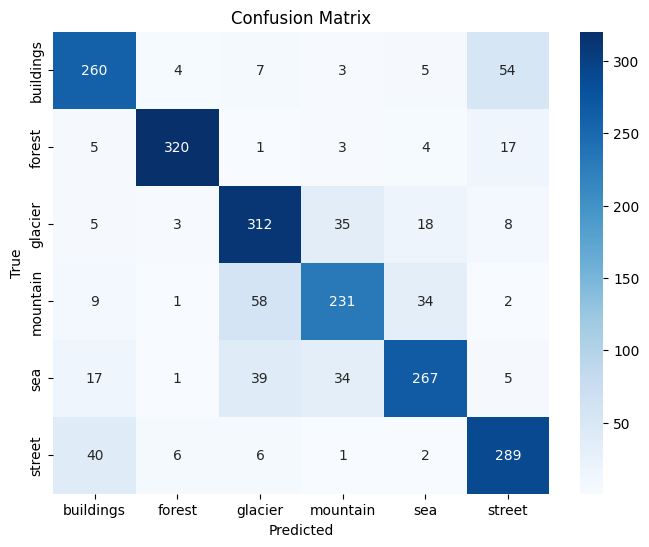

In [21]:
evaluate_model(model, test_loader, class_names)


## Заключение

В ходе лабораторной работы были реализованы и проанализированы различные подходы к решению задачи классификации изображений с использованием датасета Intel Image Classification. Проведено сравнение моделей: предобученной `ResNet18` из torchvision, улучшенной версии `ResNet18`, а также собственной сверточной нейронной сети, реализованной вручную.

### Основные результаты:
- **ResNet18** показала высокое качество классификации (до 92% точности), особенно по классам `sea`, `forest`, `street`.
- **Улучшенная версия ResNet18**, обученная с использованием аугментаций, другого оптимизатора и планировщика обучения, подтвердила устойчивость к переобучению и продемонстрировала наилучшее F1-качество по сложным классам (`glacier`, `mountain`).
- **Собственная CNN** без улучшений достигла точности ~82%. После применения техник улучшения (аугментации, scheduler, SGD), её точность составила **80%**, что всё равно ниже по сравнению с ResNet18, но приемлемо для простой модели.
- Наибольшие трудности наблюдались в различении классов `glacier`, `mountain`, `street` — как для собственных, так и для ResNet-моделей.

### Вывод:

Модели из `torchvision` с предобученными весами уверенно превосходят по качеству собственную реализацию, особенно при ограниченном количестве эпох. Тем не менее, ручная реализация модели полезна для понимания архитектуры CNN и может служить основой для дальнейших экспериментов, включая оптимизацию под конкретные условия или ресурсы.
